# Feature Selecection

In [1]:
import json


# Remove Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# General
import numpy as np


# Data Management
import pandas as pd
from sklearn.model_selection import train_test_split


# Machine Learning
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold


# BINARY CLASSIFICATION METRICS
from sklearn.metrics import RocCurveDisplay


# Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


# Reporting
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from xgboost import plot_tree

# Import Processed Data

In [2]:
# FETCH DATA
df = pd.read_csv("data/BTC-USD.csv")
df.set_index("Date" , inplace=True)

# Specify Prediction Target

In [3]:
# Specify Target     (if yesterdays range was greater than the average range)
df.loc[df["Range"].shift(-1) > df["AVG_Range"] , "TARGET"] = 1
df.loc[df["Range"].shift(-1) <= df["AVG_Range"] , "TARGET"] = 0

# Check for NAN
nan_location = np.where(np.isnan(df))

# Fill NaNs
df["TARGET"].fillna(0,inplace=True)
df.tail()

,Open,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Return,MA_12,MA_21,...,Rolling_rets,AVG_Range,Returns_T1,Range_T1,Rolling_rets_T1,Returns_T2,Range_T2,Rolling_rets_T2,HMM,TARGET
Date,,,,,,,,,,,,,,,,,,,,,
2023-10-26,0.017344,34156.648438,-0.230738,-0.010033,0.031709,4.212910,83.791364,0.953580,30532.125326,29169.758557,...,0.273831,0.031794,0.017736,0.042263,0.280775,0.024641,0.069027,0.264625,2,0.0
2023-10-27,-0.010080,33909.800781,-0.154894,-0.007227,0.024578,4.174920,80.907241,0.965580,31094.637695,29453.720610,...,0.261437,0.031711,-0.010033,0.031709,0.273831,0.017736,0.042263,0.280775,2,0.0
2023-10-28,-0.007283,34089.574219,-0.381148,0.005302,0.015486,4.202323,81.409117,1.006203,31558.813314,29745.184152,...,0.241358,0.031047,-0.007227,0.024578,0.261437,-0.010033,0.031709,0.273831,0,0.0
2023-10-29,0.005357,34538.480469,0.098421,0.013168,0.023439,4.269802,82.636497,1.015077,32069.041016,30059.631324,...,0.258591,0.031200,0.005302,0.015486,0.241358,-0.007227,0.024578,0.261437,0,0.0
2023-10-30,0.012977,34502.363281,0.539817,-0.001046,0.021488,4.263942,82.166476,0.994312,32583.542806,30389.092541,...,0.255457,0.031665,0.013168,0.023439,0.258591,0.005302,0.015486,0.241358,2,0.0


# TRAIN TEST SPLIT

In [4]:
# FETCH RECOMMENDED FEATURES FROM FEATURE SELECTION
with open('./data/feature_selection_output.json', 'r') as f:
    recommended_labels = json.load(f)
recommended_labels.append("TARGET")
recommended_labels

['Returns',
 'Range',
 'RSI',
 'MA_12',
 'DOW',
 'AVG_Range',
 'Range_T1',
 'Rolling_rets_T2',
 'HMM',
 'TARGET']

In [5]:
# REMOVE UNWANTED COLUMNS (dont put information about the future in your data other than the target)
df_tts = df.copy()
df_tts = df_tts[recommended_labels]

In [6]:
# EVERYTHING EXCEPT TARGET (x)
X = df_tts.iloc[: , : -1]

# TARGET (y)
y = df_tts.iloc[: , -1]
df_tts 

,Returns,Range,RSI,MA_12,DOW,AVG_Range,Range_T1,Rolling_rets_T2,HMM,TARGET
Date,,,,,,,,,,
2022-11-24,-0.000376,0.016344,40.295294,16508.876383,3,0.044158,0.028922,-0.161565,0,0.0
2022-11-25,-0.004976,0.013114,39.672291,16522.916097,4,0.043164,0.016344,-0.124248,2,0.0
2022-11-26,-0.003484,0.015267,39.217384,16510.089600,5,0.042688,0.013114,-0.163407,2,0.0
2022-11-27,-0.001194,0.009575,39.052718,16473.424072,6,0.041947,0.015267,-0.201951,2,0.0
2022-11-28,-0.013822,0.026684,37.111945,16435.747640,0,0.042153,0.009575,-0.182104,2,0.0
...,...,...,...,...,...,...,...,...,...,...
2023-10-26,-0.010033,0.031709,83.791364,30532.125326,3,0.031794,0.042263,0.264625,2,0.0
2023-10-27,-0.007227,0.024578,80.907241,31094.637695,4,0.031711,0.031709,0.280775,2,0.0
2023-10-28,0.005302,0.015486,81.409117,31558.813314,5,0.031047,0.024578,0.273831,0,0.0


In [7]:
# TRAIN TEST SPLIT (time series)


# 70% OF THE HISTORICAL DATA GOES TO TRAINING THE MODEL
train_amount_percent = 0.7
train_size = int(len(X) * train_amount_percent)
X_train = X.head(train_size)
y_train = y.head(train_size)


# THE REST GOES TO TESTING THE MODEL FOR ACCURACY
test_size = len(X) - train_size
X_test = X.tail(test_size)
y_test = y.tail(test_size)

In [8]:
size_check = len(y_test) + len(y_train) == len(X)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print()
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")
print()
print(f"Testing data size check: {size_check}")

Shape of X_train: (238, 9)
Shape of y_train: (238,)

Shape of X_test: (103, 9)
Shape of y_test: (103,)

Testing data size check: True


# BUILD MODEL

In [9]:
# Select type of model to optimize for
is_binary = True
is_optimize_for_precision = True


In [10]:
# Determine Objective and Eval Metrics
if is_binary:
    objective = "binary:logistic"
    eval_metric = "logloss"
    eval_metric_list = ["error","logloss",eval_metric]
else:
    objective = "multi:softmax"
    eval_metric = "mlogloss"
    eval_metric_list = ["merror","mlogloss",eval_metric]

In [11]:
# Refine Eval Metric
if is_binary and is_optimize_for_precision:
    eval_metric = "aucpr"
    scoring = "precision"
elif is_binary and not is_optimize_for_precision:
    eval_metric = "auc"
    scoring = "f1"
else:
    scoring = "accuracy"

In [12]:
# hyperparameters generated in feature selection


with open('./data/hyperparametertuning.json', 'r') as f:
    data = json.load(f)
    ne = data['ne']
    lr = data['lr']
    md = data['md']
    gm = data['gm']




# CUSTOM HYPER PARAM TUNE
# ne = 150
# lr = 0.01
# md = 4
# gm = 6


In [13]:
# Build First Classifier Model
classifier = XGBClassifier(
    objective=objective,
    booster="gbtree",
    # eval_metric=eval_metric,
    subsample = 0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False,

    n_estimators=ne,
    learning_rate=lr,
    max_depth=md,
    gamma=gm,
)

d:\Programs\Anaconda\envs\ML-finance\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [14]:
# Fit the model
eval_set = [(X_train,y_train) , (X_test,y_test)]

classifier.fit(
    X_train,
    y_train,
    eval_metric=eval_metric_list,
    eval_set=eval_set,
    verbose=False
)


d:\Programs\Anaconda\envs\ML-finance\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.2, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

# MAKE PREDICTIONS
- binary if the next day will be up (1) or down (0) the next day 

In [15]:
# training data
next_day_target_predictions = classifier.predict(X_train)
train_yhat_probability = classifier.predict_proba(X_train)


# OUTPUT
prediction_probabilities = zip(next_day_target_predictions , train_yhat_probability)
print("Predcition \t|\t Binary Confidence (zero or one)")
print("___________________________________________________\n")
for prediction , probability_confidence in list(prediction_probabilities)[:10]:
    print(prediction, "\t\t|\t",  probability_confidence)

Predcition 	|	 Binary Confidence (zero or one)
___________________________________________________

0 		|	 [0.87914276 0.12085721]
0 		|	 [0.8940493  0.10595073]
0 		|	 [0.8901134 0.1098866]
0 		|	 [0.87561905 0.12438096]
0 		|	 [0.80160064 0.19839938]
1 		|	 [0.4607823 0.5392177]
0 		|	 [0.7024163 0.2975837]
0 		|	 [0.8631526  0.13684738]
0 		|	 [0.89562577 0.10437422]
0 		|	 [0.88807964 0.11192034]


# TEST MODEL ACCURACY

In [16]:
# TEST Y HAT
test_next_day_target_predictions = classifier.predict(X_test)
test_yhat_probability = classifier.predict_proba(X_test)


# OUTPUT
prediction_probabilities = zip(test_next_day_target_predictions , test_yhat_probability)
print("Predcition \t|\t Binary Confidence (zero or one)")
print("___________________________________________________\n")
for prediction , probability_confidence in list(prediction_probabilities)[:10]:
    print(prediction, "\t\t|\t",  probability_confidence)

Predcition 	|	 Binary Confidence (zero or one)
___________________________________________________

0 		|	 [0.6343528  0.36564723]
0 		|	 [0.7748464  0.22515363]
0 		|	 [0.73928106 0.2607189 ]
1 		|	 [0.440845 0.559155]
0 		|	 [0.5429249  0.45707512]
0 		|	 [0.56365526 0.43634477]
0 		|	 [0.58591205 0.41408795]
0 		|	 [0.65688956 0.3431104 ]
0 		|	 [0.6454186  0.35458142]
0 		|	 [0.61960447 0.38039556]


# K FOLD CROSS VALIDATION

In [17]:
# KFOLD CROSS VALIDATION
cv = RepeatedStratifiedKFold(n_splits=5 , n_repeats=1, random_state=1)

In [18]:
# Training results 
train_results = cross_val_score(classifier, X_train, y_train , cv=cv , n_jobs=1 )

d:\Programs\Anaconda\envs\ML-finance\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
d:\Programs\Anaconda\envs\ML-finance\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


d:\Programs\Anaconda\envs\ML-finance\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
d:\Programs\Anaconda\envs\ML-finance\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
d:\Programs\Anaconda\envs\ML-finance\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


# EVALUTION METRICS - Loss & Overfitting

In [19]:
# Retrieve performance metrics
results = classifier.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0,epochs)

Text(0.5, 1.0, 'XGB LogLoss')

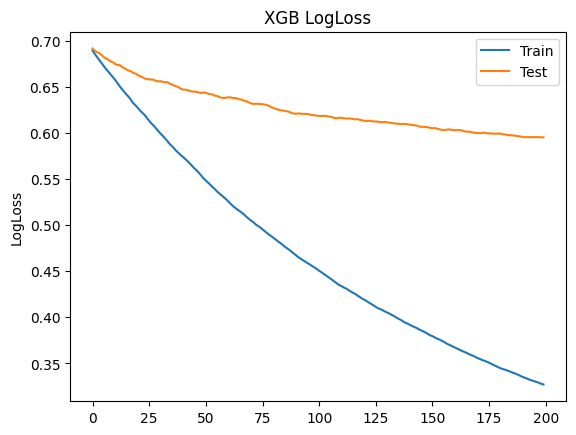

In [20]:
# Plot log loss
fig,axis = plt.subplots()
axis.plot(x_axis , results["validation_0"]["logloss"], label="Train")
axis.plot(x_axis , results["validation_1"]["logloss"], label="Test")
axis.legend()
plt.ylabel("LogLoss")
plt.title("XGB LogLoss")

Text(0.5, 1.0, 'XGB Error')

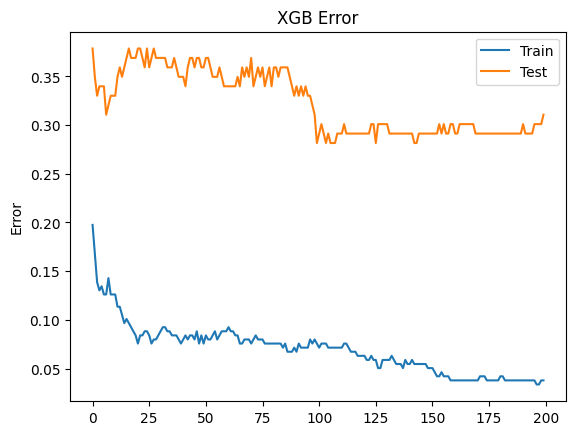

In [21]:
# Plot error
fig,axis = plt.subplots()
axis.plot(x_axis , results["validation_0"]["error"], label="Train")
axis.plot(x_axis , results["validation_1"]["error"], label="Test")
axis.legend()
plt.ylabel("Error")
plt.title("XGB Error")

# Evaluate ROC Curve

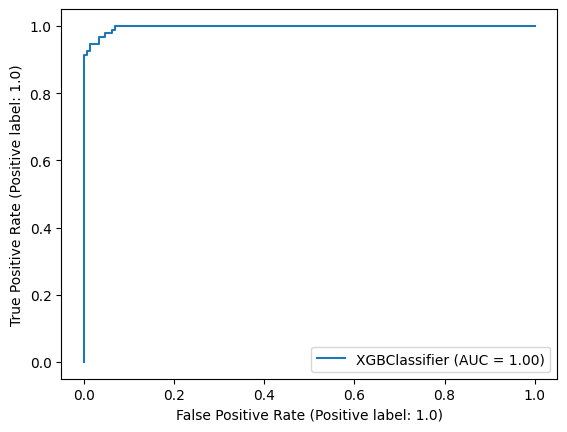

In [22]:
# Plot Training ROC Curve
RocCurveDisplay.from_estimator(classifier, X_train, y_train)

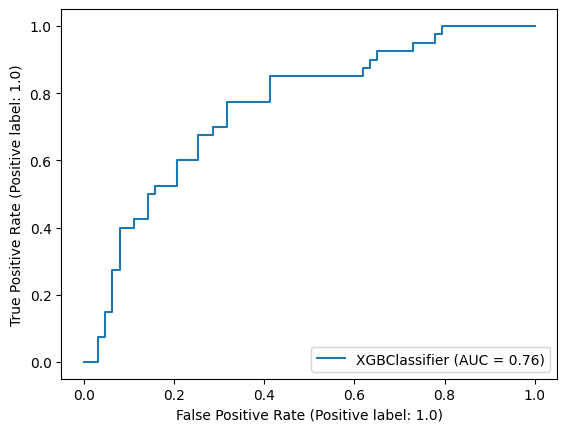

In [23]:
# Plot Test ROC Curve
RocCurveDisplay.from_estimator(classifier, X_test, y_test)

# Performance Evaluation Comparison

In [24]:
# Set K-Fold cross validation 
cv = RepeatedStratifiedKFold(n_splits=5 , n_repeats=1, random_state=1)

In [25]:
# training results
train_results  =  cross_val_score(classifier , X_train, y_train, scoring=scoring, cv=cv , n_jobs=-1)
test_results  =  cross_val_score(classifier , X_test, y_test, scoring=scoring, cv=cv , n_jobs=-1)

d:\Programs\Anaconda\envs\ML-finance\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
d:\Programs\Anaconda\envs\ML-finance\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [26]:
# Comparison of results 
print("TRAIN:", )
print("\tAverage Accuracy k-Fold",round(train_results.mean(),2) )
print("\tStandard Deviation k-Fold",round(train_results.std(),2) )
print("\tPrecision Score 0:", round(precision_score(y_train, next_day_target_predictions, average=None)[0] , 3) )
print("\tPrecision Score 1:", round(precision_score(y_train, next_day_target_predictions, average=None)[1] , 3) )
print("\n-----------------------------------------------------------------------------\n")
print("TEST:", )
print("\tAverage Accuracy k-Fold",round(test_results.mean(),2) )
print("\tStandard Deviation k-Fold",round(test_results.std(),2) )
print("\tPrecision Score 0:", round(precision_score(y_test, test_next_day_target_predictions, average=None)[0] , 3) )
print("\tPrecision Score 1:", round(precision_score(y_test, test_next_day_target_predictions, average=None)[1] , 3) )
print("\n-----------------------------------------------------------------------------\n")

TRAIN:
	Average Accuracy k-Fold 0.54
	Standard Deviation k-Fold 0.09
	Precision Score 0: 0.954
	Precision Score 1: 0.977

-----------------------------------------------------------------------------

TEST:
	Average Accuracy k-Fold 0.66
	Standard Deviation k-Fold 0.19
	Precision Score 0: 0.725
	Precision Score 1: 0.618

-----------------------------------------------------------------------------



# Evalutation Metrics - Summary Report
- looking at  `training` data prediction accuracy

In [27]:
print (classification_report(y_train, next_day_target_predictions))

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97       146
         1.0       0.98      0.92      0.95        92

    accuracy                           0.96       238
   macro avg       0.97      0.96      0.96       238
weighted avg       0.96      0.96      0.96       238



- looking at `testing` data prediction accuracy

In [28]:
print (classification_report(y_test, test_next_day_target_predictions))

              precision    recall  f1-score   support

         0.0       0.72      0.79      0.76        63
         1.0       0.62      0.53      0.57        40

    accuracy                           0.69       103
   macro avg       0.67      0.66      0.66       103
weighted avg       0.68      0.69      0.68       103



# Performance Evaluation - Confusion Matrix

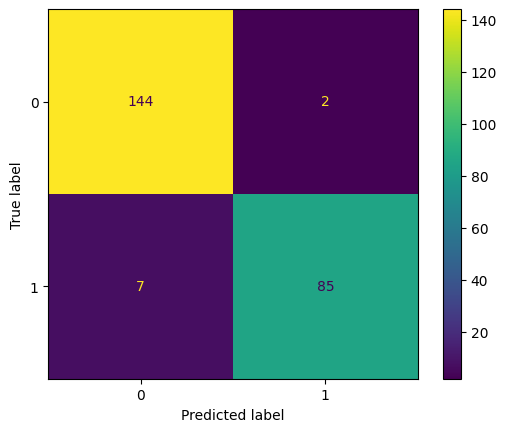

In [29]:
# Training Confusion Matrix
cm_train = confusion_matrix(y_train, next_day_target_predictions)
ConfusionMatrixDisplay(cm_train).plot()

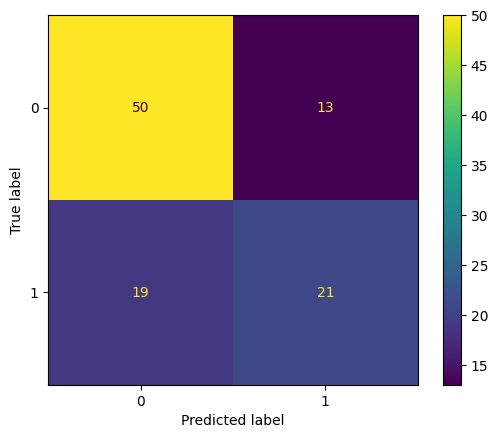

In [30]:
# Testing Confusion Matrix
cm_test = confusion_matrix(y_test, test_next_day_target_predictions)
ConfusionMatrixDisplay(cm_test).plot()

# Feature Importance
- most influential features on decision making

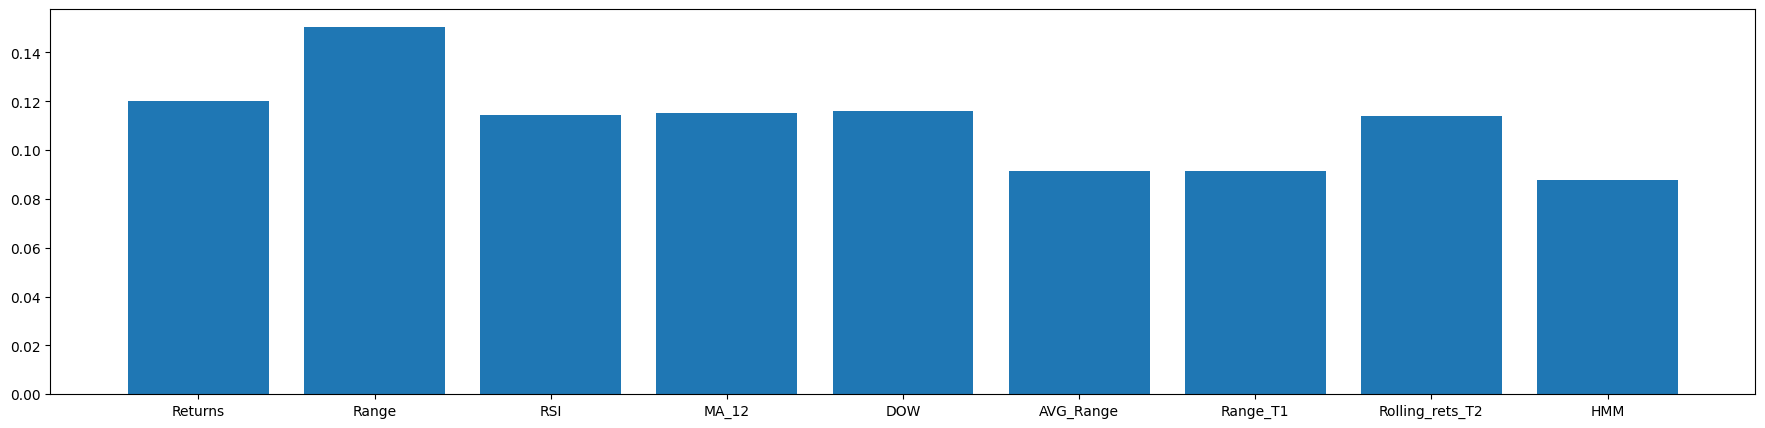

In [31]:
# Plot Feature Importance 
fig = plt.figure(figsize=(22,5))
importance_labels = X.columns
importance_features = classifier.feature_importances_
plt.bar(importance_labels, importance_features)
plt.show()

### XG BOOST TREE

In [32]:
# # Plot Decision Tree
# import os
# os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'
# rcParams["figure.figsize"] = 80,50
# plot_tree(classifier)